# Potato Disease Classification

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import data into tensorflow dataset object

In [2]:
# Constants
IMAGE_SIZE = 224  # Replace with your desired image size
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/plantvillage/Dataset1'  # Path to your dataset directory
CLASS_NAMES = os.listdir(DATASET_DIR)

# Prepare a list of all image paths and corresponding labels
image_paths = []
labels = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [3]:
# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['label'], random_state=42)  # 0.25 x 0.8 = 0.2


In [4]:
# Data Augmentation and Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True
)

train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to maintain order for evaluation
)

Found 12383 validated image filenames belonging to 15 classes.
Found 4128 validated image filenames belonging to 15 classes.
Found 4127 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [5]:
# Get class indices
class_indices = train_generator.class_indices

# Map class names to their image counts
class_counts_dict = train_data['label'].value_counts().to_dict()

# Create a list of counts in the order of train_generator.class_indices
ordered_counts = [(class_name, class_counts_dict.get(class_name, 0)) for class_name in class_indices.keys()]

# Convert to a DataFrame for better visualization
ordered_counts_df = pd.DataFrame(ordered_counts, columns=['Class Name', 'Image Count'])

# Print the ordered counts
print(ordered_counts_df)



                                     Class Name  Image Count
0                 Pepper__bell___Bacterial_spot          598
1                        Pepper__bell___healthy          886
2                         Potato___Early_blight          600
3                          Potato___Late_blight          600
4                              Potato___healthy           92
5                         Tomato_Bacterial_spot         1276
6                           Tomato_Early_blight          600
7                            Tomato_Late_blight         1145
8                              Tomato_Leaf_Mold          571
9                     Tomato_Septoria_leaf_spot         1063
10  Tomato_Spider_mites_Two_spotted_spider_mite         1006
11                          Tomato__Target_Spot          842
12        Tomato__Tomato_YellowLeaf__Curl_Virus         1925
13                  Tomato__Tomato_mosaic_virus          224
14                               Tomato_healthy          955


## Building the Model

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.layers import Flatten, Dense

strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in vgg_base.layers:
        layer.trainable = False
    
    # Add custom layers on top of the VGG16 base
    x = vgg_base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(vgg_base.output)
    x = Dense(32, activation='relu')(x)  # Custom fully connected layer
    x = Dense(15, activation='softmax')(x)  # Output layer for 4 classes
    
    # Create the complete model
    model = Model(inputs=vgg_base.input, outputs=x)
        
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','Precision', 'Recall'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,4

 Total params: 14,731,599 (56.20 MB)

 Trainable params: 16,911 (66.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [8]:
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=validation_generator,
    epochs=30
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 228s 564ms/step - Precision: 0.5661 - Recall: 0.0114 - accuracy: 0.2519 - loss: 2.4213 - val_Precision: 0.9377 - val_Recall: 0.1604 - val_accuracy: 0.5039 - val_loss: 1.6549
Epoch 2/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 187s 477ms/step - Precision: 0.9127 - Recall: 0.2075 - accuracy: 0.5724 - loss: 1.4941 - val_Precision: 0.9061 - val_Recall: 0.3178 - val_accuracy: 0.6172 - val_loss: 1.2518
Epoch 3/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 186s 474ms/step - Precision: 0.9056 - Recall: 0.3697 - accuracy: 0.6496 - loss: 1.1578 - val_Precision: 0.8769 - val_Recall: 0.4486 - val_accuracy: 0.6739 - val_loss: 1.0427
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 187s 477ms/step - Precision: 0.9025 - Recall: 0.4656 - accuracy: 0.6952 - loss: 0.9916 - val_Precision: 0.8970 - val_Recall: 0.5063 - val_accuracy: 0.7127 - val_loss: 0.9176
Epoch 5/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 188s 480ms/step - Precision: 0.8985 - Recall: 0.5345 - accuracy: 0.7249 - loss: 0.8624 - val_Precision: 

In [9]:
# Evaluate on train data
train_scores = model.evaluate(train_generator, verbose=1)
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]:.4f}")

# Evaluate on test data
test_scores = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]:.4f}")


387/387 ━━━━━━━━━━━━━━━━━━━━ 139s 358ms/step - Precision: 0.9165 - Recall: 0.8438 - accuracy: 0.8786 - loss: 0.3582
Train Loss: 0.3557, Train Accuracy: 0.8821
129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 490ms/step - Precision: 0.9186 - Recall: 0.8429 - accuracy: 0.8783 - loss: 0.3656
Test Loss: 0.3904, Test Accuracy: 0.8692


In [10]:
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score


# Get true labels and predicted labels
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices


129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step


In [11]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.93      0.86      0.89       199
                     Pepper__bell___healthy       0.95      0.96      0.95       296
                      Potato___Early_blight       0.92      0.92      0.92       200
                       Potato___Late_blight       0.81      0.93      0.87       200
                           Potato___healthy       0.93      0.83      0.88        30
                      Tomato_Bacterial_spot       0.88      0.96      0.91       426
                        Tomato_Early_blight       0.70      0.56      0.62       200
                         Tomato_Late_blight       0.89      0.76      0.82       382
                           Tomato_Leaf_Mold       0.74      0.79      0.76       190
                  Tomato_Septoria_leaf_spot       0.83      0.78      0.81       354
Tomato_Spider_mites_Two_spotted_spider_mi

In [12]:
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='weighted')  # Weighted average for class imbalance
overall_recall = recall_score(y_true, y_pred, average='weighted')
overall_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")

Overall Accuracy: 0.8679
Overall Precision: 0.8678
Overall Recall: 0.8679
Overall F1-Score: 0.8662


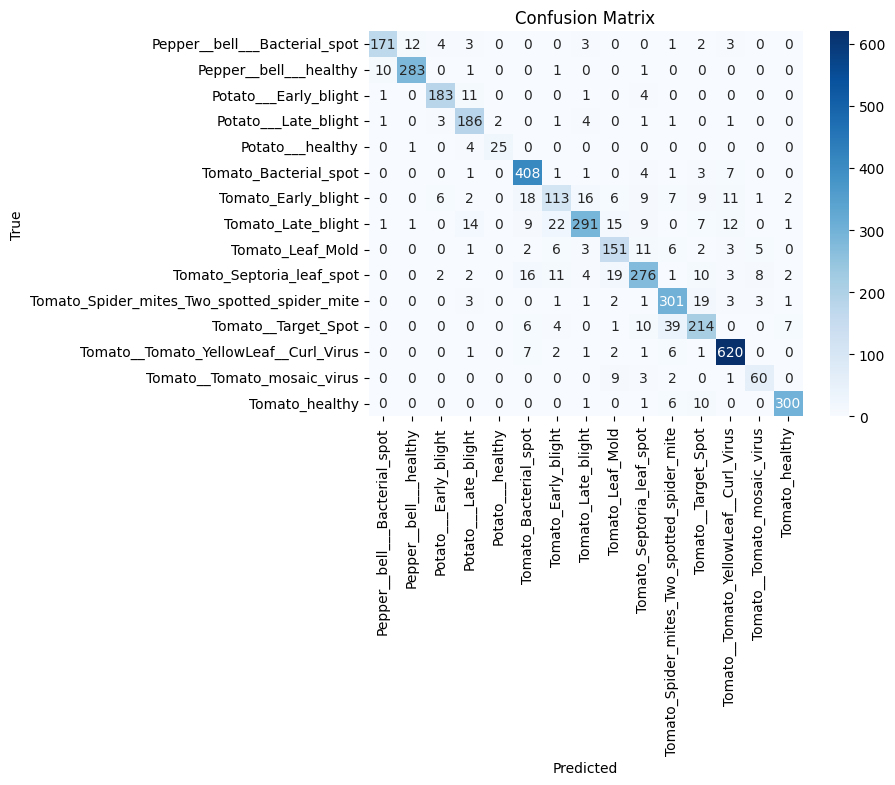

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
import numpy as np
specificity = []

for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

overall_specificity = np.mean(specificity)  # Average specificity

print(f"Overall Specificity: {overall_specificity:.4f}")

Overall Specificity: 0.9905


In [20]:
# Sensitivity (Recall)
def calculate_specificity(cm, CLASS_NAMES):

    # Specificity
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp))

    print("\nPer-Class Specificity:")
    for idx, class_name in enumerate(CLASS_NAMES):
        print(f"Class {class_name}: {specificity[idx]:.4f}")

    return specificity

In [21]:
# print("\n--- Train Data Metrics ---")
specificity = calculate_specificity(cm, CLASS_NAMES)


Per-Class Specificity:
Class Pepper__bell___Bacterial_spot: 0.9967
Class Potato___healthy: 0.9963
Class Tomato_Leaf_Mold: 0.9962
Class Tomato__Tomato_YellowLeaf__Curl_Virus: 0.9891
Class Tomato_Bacterial_spot: 0.9995
Class Tomato_Septoria_leaf_spot: 0.9843
Class Tomato_healthy: 0.9875
Class Tomato_Spider_mites_Two_spotted_spider_mite: 0.9907
Class Tomato_Early_blight: 0.9863
Class Tomato__Target_Spot: 0.9854
Class Pepper__bell___healthy: 0.9815
Class Potato___Late_blight: 0.9836
Class Tomato_Late_blight: 0.9874
Class Potato___Early_blight: 0.9958
Class Tomato__Tomato_mosaic_virus: 0.9966


In [22]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Create a DataFrame for the class-wise accuracies
class_accuracy_df = pd.DataFrame({
    "Class": list(test_generator.class_indices.keys()),
    "Accuracy": class_accuracies
})

print("\nClass-wise Accuracies:")
print(class_accuracy_df.to_string(index=False))


Class-wise Accuracies:
                                      Class  Accuracy
              Pepper__bell___Bacterial_spot  0.859296
                     Pepper__bell___healthy  0.956081
                      Potato___Early_blight  0.915000
                       Potato___Late_blight  0.930000
                           Potato___healthy  0.833333
                      Tomato_Bacterial_spot  0.957746
                        Tomato_Early_blight  0.565000
                         Tomato_Late_blight  0.761780
                           Tomato_Leaf_Mold  0.794737
                  Tomato_Septoria_leaf_spot  0.779661
Tomato_Spider_mites_Two_spotted_spider_mite  0.898507
                        Tomato__Target_Spot  0.761566
      Tomato__Tomato_YellowLeaf__Curl_Virus  0.967239
                Tomato__Tomato_mosaic_virus  0.800000
                             Tomato_healthy  0.943396


### Run prediction on a sample image

In [23]:
import random
from tensorflow.keras.preprocessing import image

random_indices = random.sample(range(len(y_true)), 15)

class_names = list(test_generator.class_indices.keys())

# Iterate through the random indices and display actual and predicted results
for idx in random_indices:
    actual_class = class_names[y_true[idx]]
    predicted_class = class_names[y_pred[idx]]
    print(f"Actual: {actual_class} ,  Predicted: {predicted_class}")

Actual: Pepper__bell___healthy ,  Predicted: Pepper__bell___healthy
Actual: Potato___Early_blight ,  Predicted: Potato___Early_blight
Actual: Potato___Early_blight ,  Predicted: Potato___Early_blight
Actual: Tomato__Tomato_YellowLeaf__Curl_Virus ,  Predicted: Tomato__Tomato_YellowLeaf__Curl_Virus
Actual: Tomato__Tomato_YellowLeaf__Curl_Virus ,  Predicted: Tomato__Tomato_YellowLeaf__Curl_Virus
Actual: Pepper__bell___healthy ,  Predicted: Pepper__bell___healthy
Actual: Tomato_Spider_mites_Two_spotted_spider_mite ,  Predicted: Tomato_Spider_mites_Two_spotted_spider_mite
Actual: Tomato_Early_blight ,  Predicted: Tomato_Late_blight
Actual: Tomato__Tomato_YellowLeaf__Curl_Virus ,  Predicted: Tomato__Tomato_YellowLeaf__Curl_Virus
Actual: Tomato__Target_Spot ,  Predicted: Tomato__Target_Spot
Actual: Tomato_Early_blight ,  Predicted: Tomato_Early_blight
Actual: Tomato__Tomato_mosaic_virus ,  Predicted: Tomato__Tomato_mosaic_virus
Actual: Pepper__bell___healthy ,  Predicted: Pepper__bell___healt